In [638]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as scisig
import scipy.optimize as opt
import scipy.io as sio
import simulation_utils as su
import analysis_utils as au
import importlib

In [20]:
# Define some parameters

w0 = 55000*2*np.pi # Natural frequency of oscillator
P = 1*10**(-7) # Pressure in mbar
T = 293 # Environmental temperature
R = (0.083)*10**(-6) # Particle Radius
p = 2200 # Particle Denisty
dtn = 1*10**(-8) # Timestep
M = 4/3*np.pi*R**3*p # Particle mass
kb = 1.38*10**(-23) # Boltzmann constant
m = 29*1.67*10**(-27) # average mass of air particles
v = np.sqrt(8*1.38*10**(-23)*T/(np.pi*m)) # velocity of air particles
N0 = 2.43*10**(25) # Number density of air and ambient pressure
P0 = 1000 # Ambient pressure
N=N0*P/P0 # Number density of air at pressure P

y = (4/3*np.pi)*(m*v*N*R**2)/(M) # Damping from air
#y = 4.10568*1e-6*P*1e2/R # Antonio's damping from air

print(y)

Snn = 10**(-28) # Displacement noise

0.00029717080823618027


# Generating impulses and noise for a stationary transfer function oscillator

In [ ]:
# Simulation
# This block generates the data and saves it
# Calculating num_sims numbers of simulations with and without response
# Also generating average response to impulse and noise template

num_sims = 1000

# feedback damping values to use
yfb_l = np.array([10000, 1000, 100, 10, 1])*2*np.pi

for yfb in yfb_l:
    filename = 'D:/Simulation Data/240501/yfb' + str(round(yfb/2/np.pi))

    # Some set-up
    maxw = 5*10**5 # 500 kHz is enough to capture all dynamics
    numbins = int(2*5*10**4*100*2*np.pi/yfb) # This is to ensure the particle amplitude decays to thermal levels
    w = np.linspace(0, maxw*2*np.pi, numbins)
    
    # Generate impulse response
    time = np.linspace(0, numbins/5/10**5/2, numbins)
    ir = su.impulse_resp(time, time[int(numbins/2)], 10*10**(-10), y+yfb, w0) # Same impulse response every time so generate it here

    # Generate some random number seeds
    np.random.seed(85655219)
    random_nums = np.random.uniform(0, 1000000, 6*num_sims) # These are the seeds we will use
    
    # Set-up arrays for calculating average response (s in optimal filter/data to fit s to)
    avr_resp = np.zeros(numbins)
    
    # Now generate num_sims different thermally driven particles and add the impulse response
    for i in range(num_sims):
        randomlist, randomlist2, randomlist3 = su.generate_random_numbers(random_nums[3*i:3*(i+1)], Snn, numbins, maxw)
        x = su.generate_displacement(w, w0, y, yfb, randomlist, randomlist2, randomlist3, ir)

        # Save the time domain response
        mdict = {'x': x}
        sio.savemat(filename+'/Kicks/' + str(i) + '.mat', mdict)

        # Add to average response
        avr_resp += x

    # Save average response to use as template/template fit
    avr_resp /= num_sims
    mdict = {'x':avr_resp}
    sio.savemat(filename+'/Kicks/avr_resp.mat', mdict)

    # Generate nums_sims new thermally driven particles with no impulse response to create noise template and to run optimal filter on for comparison

    # Set-up array for noise template (J in optimal filter)
    PSD_noise = np.zeros(int(numbins/2)+1)

    # Create empty array for impulse response because we don't want and impulse
    ir = np.zeros(numbins)

    for i in range(num_sims, 2*num_sims):
        n = i-num_sims
        randomlist, randomlist2, randomlist3 = su.generate_random_numbers(random_nums[3*i:3*(i+1)], Snn, numbins, maxw)
        x = su.generate_displacement(w, w0, y, yfb, randomlist, randomlist2, randomlist3, ir)

        # Save the time domain response
        mdict = {'x': x}
        sio.savemat(filename+'/Noise/' + str(n) + '.mat', mdict)

        # Calculate PSD and add to J
        PSD = scisig.welch(x, fs = 10**6, nperseg = numbins)
        PSD_noise += PSD[1]

    # Save J
    PSD_noise /= num_sims
    PSD_freq = PSD[0]
    mdict = {'J':PSD_noise, 'frequency':PSD_freq}
    sio.savemat(filename+'/Noise/PSD.mat', mdict)


# Generating data for a non-stationary transfer function oscillator

In this first attempt I will try generating a stationary transfer function, reverse FTing it to time domain, create a modulated timebase then interpolate the displacement trace and finally FT back into the frequency domain. This should be the equivalent of modulating the central frequency of the oscillator. It is probably faster than doing everything in the time domain. First, I will try it on like 100 Hz data and try broadening with a sin modulation to 1 kHz or so. Then I will try it on lower damping data and time it to compare to generating stuff in the time domain.

In [517]:
importlib.reload(su)

num_sims = 100

# feedback damping values to use
yfb_l = np.array([100])*2*np.pi

for yfb in yfb_l:
    filename = 'D:/Simulation Data/240515/Frequency modulation/yfb' + str(round(yfb/2/np.pi))

    # Some set-up
    maxw = 5*10**5 # 500 kHz is enough to capture all dynamics
    numbins = int(2*5*10**4*100*2*np.pi/yfb) # This is to ensure the particle amplitude decays to thermal levels
    w = np.linspace(0, maxw*2*np.pi, numbins)

    # Generate some random number seeds
    np.random.seed(85655219)
    random_nums = np.random.uniform(0, 1000000, 3*num_sims) # These are the seeds we will use

    # Generate 1000 new thermally driven particles with no impulse response to create noise template and to run optimal filter on for comparison

    # Set-up array for noise template (J in optimal filter)
    PSD_noise = np.zeros(int(numbins/2)+1)

    # Create empty array for impulse response because we don't want and impulse
    ir = np.zeros(numbins)

    x_l = np.zeros((num_sims, numbins))

    for i in range(0, num_sims):
        n = i-num_sims
        randomlist, randomlist2, randomlist3 = su.generate_random_numbers(random_nums[3*i:3*(i+1)], 0, numbins, maxw)
        x = su.generate_displacement(w, w0, y, yfb, M, T, randomlist, randomlist2, randomlist3, ir)
        x_l[i] = x
        # Calculate PSD and add to J
        PSD = scisig.welch(x, fs = 10**6, nperseg = numbins)
        PSD_noise += PSD[1]

    # Save J
    PSD_noise /= num_sims
    PSD_freq = PSD[0]

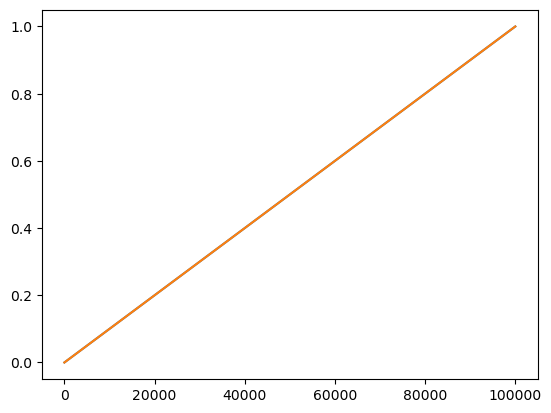

In [806]:
plt.plot(scisig.sawtooth(2*np.pi*10*time, 1)*0.5+0.5)
plt.plot(time/time[-1])

In [1110]:
time = np.linspace(0, 1/2/maxw*numbins, numbins)
#time2 = (1.03-0.03*time/time[-1])*time
time2 = foobar2
PSD_noise2 = np.zeros(int(numbins/4)+1)
for n, x in enumerate(x_l[:]):
    x_mod = np.interp(time, time2, x)
    #x_mod = x*np.exp(-1*time**2)
    x_l2[n] = x_mod

    PSD = scisig.welch(x_mod[:int(len(x_mod)/2)], fs = 10**6, nperseg = numbins/2)
    PSD2 = scisig.welch(x_mod[int(len(x_mod)/2):], fs = 10**6, nperseg = numbins/2)
    PSD_avr = (PSD[1]+PSD2[1])/2
    PSD_noise2 += PSD_avr

    #PSD = scisig.welch(x_mod[:], fs = 10**6, nperseg = numbins/2)
    P#SD_noise2 += PSD[1]

# Save J
PSD_noise2 /= num_sims
PSD_freq2 = PSD[0]

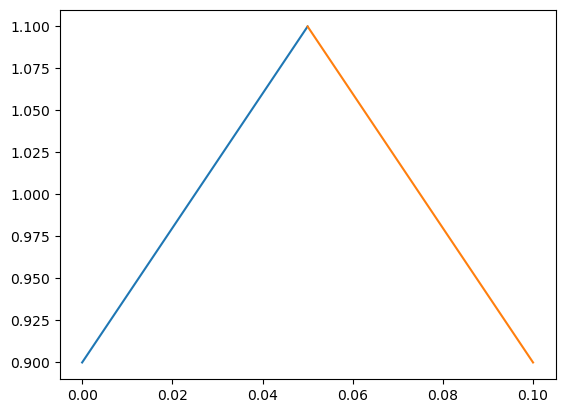

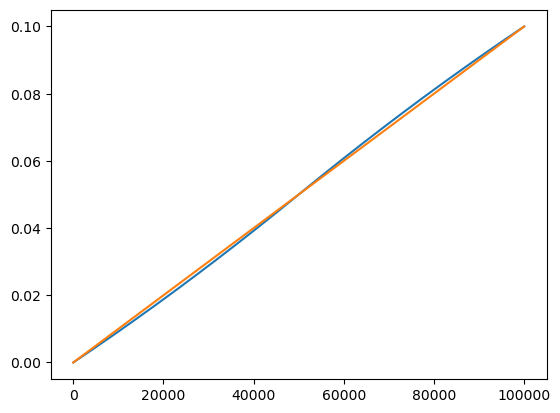

In [1111]:
ht = int(len(time)/2)
foo = (0.9+0.2*time[:ht]/time[ht])
bar = (1.3-0.2*(time[ht:])/time[ht])
plt.plot(time[:ht] , foo)
plt.plot(time[ht:], bar)
foo2 = (0.9+0.1*time[:ht]/time[ht])*time[:ht]
bar2 = (1.3-0.1*(time[:ht]+time[ht])/time[ht])*(time[ht:])-0.2*time[ht]
#time_double = np.concatenate((time, (time[:]+time[-1])))
foobar2 = np.concatenate((foo2, bar2))
#plt.plot(time, foobar)
plt.figure()
plt.plot(foobar2)
plt.plot(time)

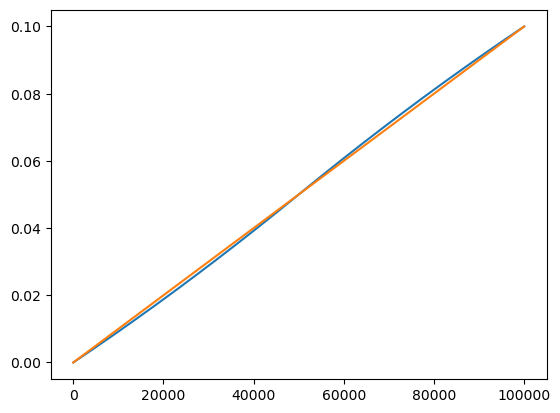

In [1112]:
plt.plot(time2)
plt.plot(time)

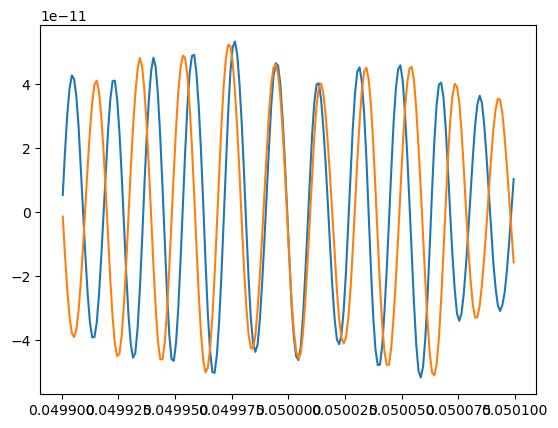

In [1113]:
lb = ht - 100
ub = ht + 100
plt.plot(time[lb:ub], x_l[0][lb:ub])
plt.plot(time[lb:ub], x_l2[0][lb:ub])

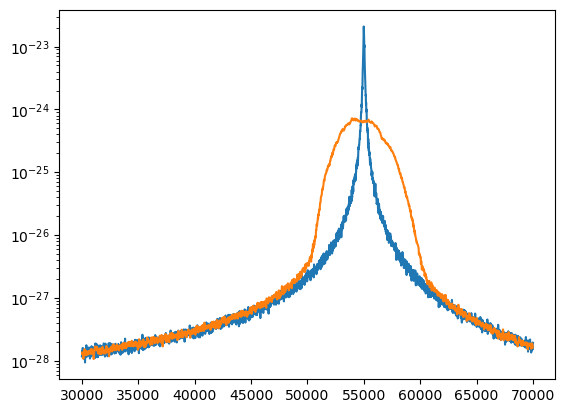

In [1114]:
lb = int(30000/10)
ub = int(70000/10)
lb2 = int(30000/20)
ub2 = int(70000/20)
plt.plot(PSD_freq[lb:ub], PSD_noise[lb:ub])
plt.plot(PSD_freq2[lb2:ub2], PSD_noise2[lb2:ub2])
plt.yscale('log')